In [23]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from Big_Cats import Test_Cats, Train_Cats

In [24]:
def display_img(img,label):
    print(f"Label : {training_data.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [26]:
batch_size = 32
num_data = 1600
learning_rate = 0.01
big_cats_train = '../CNN_Big_Cats/Big_Cats/Train_Cats'
big_cats_test = '../CNN_Big_Cats/Big_Cats/Test_Cats'

training_data = ImageFolder(big_cats_train, transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.RandomRotation(30), 
    transforms.ColorJitter(brightness=0.15, contrast=0.05, saturation=0.05, hue=0)]))

testing_data = ImageFolder(big_cats_test, transform = transforms.Compose([
    transforms.Resize((128, 128)), transforms.ToTensor()]))


train_size = len(training_data) - num_data


#For both datasets, each image is reszied to 150x150 pixels then converted to a tensor.
train_split, val_split = random_split(training_data, [train_size, num_data])


dload_train = DataLoader(train_split, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
dload_test = DataLoader(val_split, batch_size*2, num_workers = 4, pin_memory=True)
n_total_steps = len(dload_train)



print(f"Training data length: {len(train_split)}")
print(f"Training data length: {len(val_split)}")



Training data length: 200
Training data length: 1600


Image Size: torch.Size([3, 128, 128])
Which, means the image has 3 colour channels,and a length and width of 128 pixels. it has also been randomly
rotated and adjusted for brightness, hue, saturaton and potentially flipped as per our transformations.
Label : cheetah


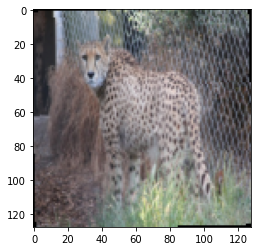

In [27]:
image, label = training_data[0]
print("Image Size: " + str(image.shape) + "\n" +"Which, means the image has 3 colour channels,\
and a length and width of 128 pixels. it has also been randomly" + "\n" +"rotated and adjusted \
for brightness, hue, saturaton and potentially flipped as per our transformations.")

display_img(image, label)



In [28]:
classes = ["hyena", 'cheetah']

print(len(classes))

2


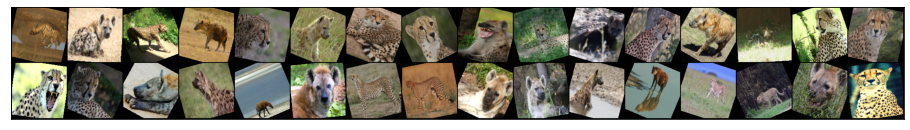

In [29]:
show_batch(dload_train)

In [30]:
# Here is where I shaped the network's layers through experimenting with
# gradually manipulating the image size through pooling and convolution.  

dataiter = iter(dload_train)
images, labels = dataiter.next()


conv1 = nn.Conv2d(3, 30, 5)
pool = nn.MaxPool2d(2, 2, padding=1)
conv2 = nn.Conv2d(30, 15, 5)

print(images.shape)

x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)

x = conv2(x)
print(x.shape)

x = pool(x)
print(x.shape)



torch.Size([32, 3, 128, 128])
torch.Size([32, 30, 124, 124])
torch.Size([32, 30, 63, 63])
torch.Size([32, 15, 59, 59])
torch.Size([32, 15, 30, 30])


In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, 5)
        self.pool = nn.MaxPool2d(4, 4, padding=1)
        self.conv2 = nn.Conv2d(30, 15, 5)
        self.fc1 = nn.Linear(15*7*7, 100) #5*14*14 because our convolving filter and pooling decrease the img size.
        self.fc2 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.5)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 15*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
    
model = CNN().to(device)

In [32]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(num_correct)
        print(num_samples)
    model.train()
    return num_correct/num_samples

In [33]:
losses = []
test_accuracies = []
train_accuracies = []

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_size = len(training_data) - num_data
num_epochs = 800


In [ ]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dload_train):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 7 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            train_accuracies.append(check_accuracy(dload_train, model).numpy())
            
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)
#loss 0.69 -> 0.001

Epoch [1/800], Step [7/7], Loss: 0.6740
tensor(124)
200
Epoch [2/800], Step [7/7], Loss: 0.7135
tensor(119)
200
Epoch [3/800], Step [7/7], Loss: 0.6668
tensor(119)
200
Epoch [4/800], Step [7/7], Loss: 0.7017
tensor(119)
200
Epoch [5/800], Step [7/7], Loss: 0.6742
tensor(119)
200
Epoch [6/800], Step [7/7], Loss: 0.6398
tensor(119)
200
Epoch [7/800], Step [7/7], Loss: 0.6875
tensor(119)
200
Epoch [8/800], Step [7/7], Loss: 0.6688
tensor(119)
200
Epoch [9/800], Step [7/7], Loss: 0.6613
tensor(119)
200
Epoch [10/800], Step [7/7], Loss: 0.6967
tensor(119)
200
Epoch [11/800], Step [7/7], Loss: 0.7134
tensor(119)
200
Epoch [12/800], Step [7/7], Loss: 0.6255
tensor(119)
200
Epoch [13/800], Step [7/7], Loss: 0.6545
tensor(119)
200
Epoch [14/800], Step [7/7], Loss: 0.7825
tensor(119)
200
Epoch [15/800], Step [7/7], Loss: 0.6651
tensor(119)
200
Epoch [16/800], Step [7/7], Loss: 0.5991
tensor(119)
200
Epoch [17/800], Step [7/7], Loss: 0.5439
tensor(119)
200
Epoch [18/800], Step [7/7], Loss: 0.5869

tensor(126)
200
Epoch [145/800], Step [7/7], Loss: 0.7400
tensor(152)
200
Epoch [146/800], Step [7/7], Loss: 0.7337
tensor(145)
200
Epoch [147/800], Step [7/7], Loss: 0.4729
tensor(153)
200
Epoch [148/800], Step [7/7], Loss: 0.5791
tensor(153)
200
Epoch [149/800], Step [7/7], Loss: 0.6779
tensor(103)
200
Epoch [150/800], Step [7/7], Loss: 0.6309
tensor(155)
200
Epoch [151/800], Step [7/7], Loss: 0.5903
tensor(149)
200
Epoch [152/800], Step [7/7], Loss: 0.3705
tensor(125)
200
Epoch [153/800], Step [7/7], Loss: 0.3501
tensor(133)
200
Epoch [154/800], Step [7/7], Loss: 0.3328
tensor(119)
200
Epoch [155/800], Step [7/7], Loss: 0.5221
tensor(158)
200
Epoch [156/800], Step [7/7], Loss: 0.5827
tensor(153)
200
Epoch [157/800], Step [7/7], Loss: 0.6398
tensor(157)
200
Epoch [158/800], Step [7/7], Loss: 0.4929
tensor(126)
200
Epoch [159/800], Step [7/7], Loss: 0.6055
tensor(125)
200
Epoch [160/800], Step [7/7], Loss: 0.4383
tensor(145)
200
Epoch [161/800], Step [7/7], Loss: 0.2487
tensor(128)
20

In [ ]:
print(losses)
print(train_accuracies)

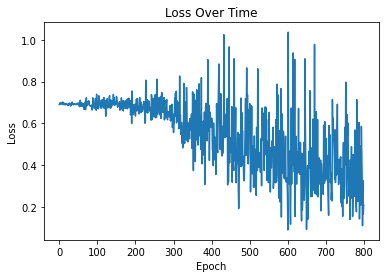

In [16]:

plt.title("Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.show()

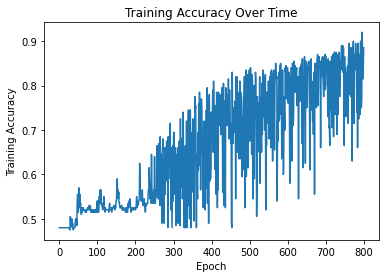

In [17]:
plt.title("Training Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(train_accuracies)
plt.show()

In [18]:
print(f"Accuracy on training set: {check_accuracy(dload_train, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(dload_test, model)*100:.2f}")

i
i
i
i
i
i
i
Accuracy on training set: 90.00
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
Accuracy on test set: 83.44
